In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
# prepare pairs of random variables to estimate the mutual information
num_samples = 10000
x = np.random.normal(loc = 0, scale = 1, size = [num_samples])
y = x + np.random.normal(loc = 0, scale = 0.9, size = [num_samples]) 
#x = np.expand_dims(x, axis = 1)
#y = np.expand_dims(y, axis = 1)

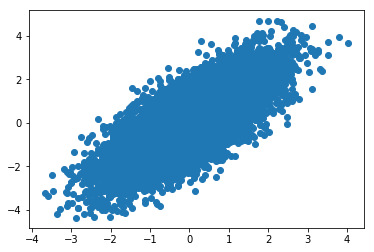

In [3]:
plt.scatter(x, y)
plt.show()

In [4]:
import tensorflow as tf

In [5]:
import tensorflow.contrib.layers as layers

In [6]:
config = tf.ConfigProto()
config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.ON_1
sess = tf.InteractiveSession(config = config)

In [7]:
batch_size = num_samples

In [8]:
data_x_in = tf.placeholder(tf.float32, [None, ], 'data_x_in')
data_y_in = tf.placeholder(tf.float32, [None, ], 'data_y_in')

In [9]:
data_y_shuffled = tf.random.shuffle(data_y_in)

In [10]:
data_x_combined = tf.concat([data_x_in, data_x_in], axis = 0)
data_y_combined = tf.concat([data_y_in, data_y_shuffled], axis = 0)

In [11]:
data_combined = tf.stack([data_x_combined, data_y_combined], axis = 1)

In [12]:
def MINE_network(data):
    with tf.variable_scope("MINE", reuse = tf.AUTO_REUSE):
        lay = layers.relu(data, 20)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 1)
        
    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = "MINE")
    
    return outputs, these_vars

In [13]:
MINE_output, MINE_vars = MINE_network(data_combined)

In [30]:
batch_size_dyn = tf.cast(tf.math.divide(tf.shape(MINE_output)[0], 2), tf.int32)

In [14]:
MINE_vars

[<tf.Variable 'MINE/fully_connected/weights:0' shape=(1, 20) dtype=float32_ref>,
 <tf.Variable 'MINE/fully_connected/biases:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'MINE/fully_connected_1/weights:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'MINE/fully_connected_1/biases:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'MINE/fully_connected_2/weights:0' shape=(20, 1) dtype=float32_ref>,
 <tf.Variable 'MINE/fully_connected_2/biases:0' shape=(1,) dtype=float32_ref>]

In [32]:
T_xy = MINE_output[:batch_size_dyn,:]
T_x_y = MINE_output[batch_size_dyn:,:]

In [33]:
MINE_loss = -(tf.reduce_mean(T_xy, axis = 0) - tf.math.log(tf.reduce_mean(tf.math.exp(T_x_y), axis = 0)))

In [34]:
train_MINE = tf.train.AdamOptimizer(learning_rate = 0.01, beta1 = 0.4, beta2 = 0.6).minimize(MINE_loss, var_list = [MINE_vars])

In [35]:
sess.run(tf.global_variables_initializer())

In [36]:
init_MINE = tf.variables_initializer(var_list = MINE_vars)

In [37]:
sess.run(init_MINE)

In [38]:
number_batches = 200

In [39]:
loss_evolution = []

In [40]:
for batch in range(number_batches):
    sess.run(train_MINE, feed_dict = {data_x_in: x, data_y_in: y})
    loss = sess.run(MINE_loss, feed_dict = {data_x_in: x, data_y_in: y})
    loss_evolution.append(-loss)

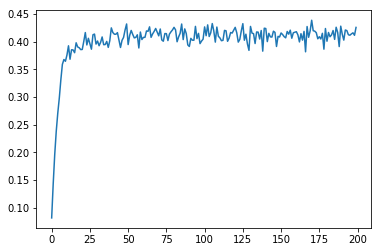

In [41]:
plt.plot(loss_evolution)
plt.show()

In [23]:
sess.close()